# Phân tích và khám phá dữ liệu MovieLens 32M

In [1]:
!pip install pyspark --quiet

## 1. Import thư viện và tạo session Spark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [3]:
from pyspark.sql import SparkSession
import sys

spark = SparkSession.builder \
    .appName("MovieLens Analytics Kaggle") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/22 19:33:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 3.5.1


## 2. Khám phá sơ bộ về dữ liệu

In [13]:
from pyspark.sql.types import StringType, StructType, StructField, IntegerType, FloatType, LongType
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc, col, from_unixtime
import matplotlib.ticker as ticker

Định nghĩa Schema cho việc đọc file CSV

In [5]:
ratings_schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", LongType(), True)
])

movies_schema = StructType([
    StructField("movieId", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("genres", StringType(), True)
])

Đọc file CSV dữ liệu

In [6]:
ratings = spark.read.csv(
    "/kaggle/input/bigdata-movies/ml-32m/ml-32m/ratings.csv",  
    sep=",",
    schema=ratings_schema,
    header=True
)

movies = spark.read.csv(
    "/kaggle/input/bigdata-movies/ml-32m/ml-32m/movies.csv",
    sep=",",
    schema=movies_schema,
    header=True
)

In [7]:
print("Ratings Schema:")
ratings.printSchema()
ratings.show(5)

Ratings Schema:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: long (nullable = true)



+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     17|   4.0|944249077|
|     1|     25|   1.0|944250228|
|     1|     29|   2.0|943230976|
|     1|     30|   5.0|944249077|
|     1|     32|   5.0|943228858|
+------+-------+------+---------+
only showing top 5 rows



In [8]:
print("Movies Schema:")
movies.printSchema()
movies.show(5)

Movies Schema:
root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



### 2.1 Khám phá dữ liệu đơn biến

#### 2.1.1 Về Rating

In [9]:
print(f"Số lượng ratings: {ratings.count()}")

Số lượng ratings: 32000204


In [10]:
ratings.groupBy("rating").count().orderBy("rating").show()

+------+-------+
|rating|  count|
+------+-------+
|   0.5| 525132|
|   1.0| 946675|
|   1.5| 531063|
|   2.0|2028622|
|   2.5|1685386|
|   3.0|6054990|
|   3.5|4290105|
|   4.0|8367654|
|   4.5|2974000|
|   5.0|4596577|
+------+-------+



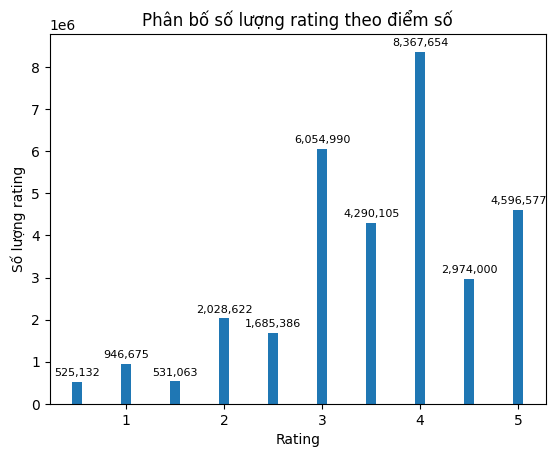

In [11]:
rating_counts_df = ratings.groupBy("rating").count().orderBy("rating")
rating_counts_pd = rating_counts_df.toPandas()

bars = plt.bar(rating_counts_pd['rating'], rating_counts_pd['count'], width=0.1)
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height):,}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=8)

plt.xlabel('Rating')
plt.ylabel('Số lượng rating')
plt.title('Phân bố số lượng rating theo điểm số')
plt.show()

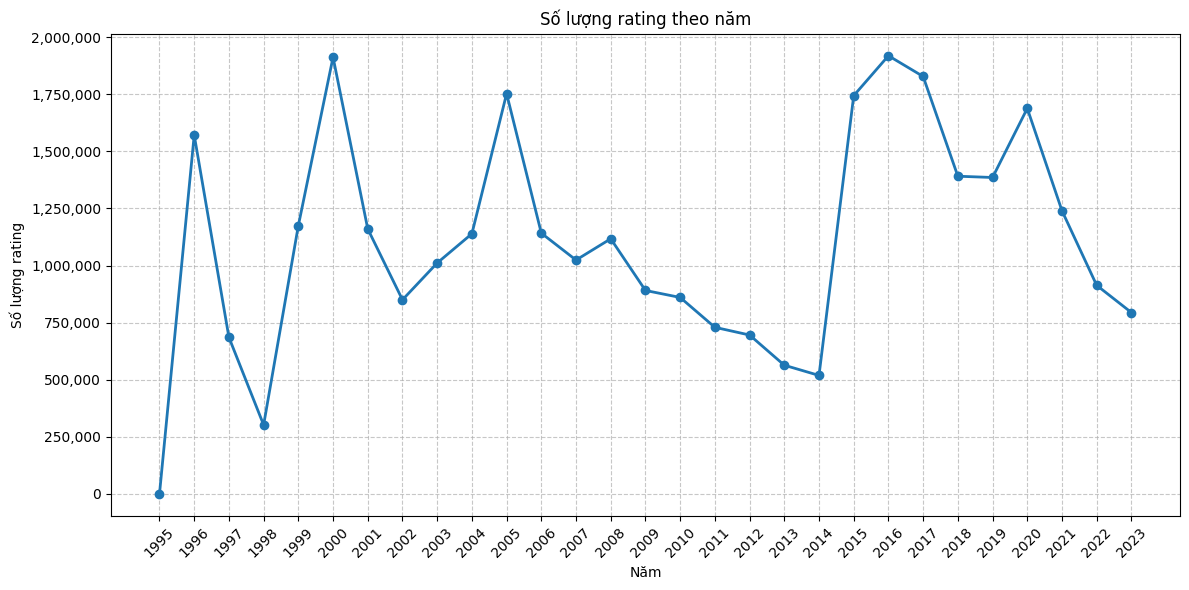

In [14]:
ratings_with_year = ratings.withColumn("year", from_unixtime(col("timestamp"), "yyyy"))
ratings_per_year = ratings_with_year.groupBy("year").count().orderBy("year")
ratings_per_year_pd = ratings_per_year.toPandas()
ratings_per_year_pd['year'] = ratings_per_year_pd['year'].astype(int)
ratings_per_year_pd = ratings_per_year_pd.sort_values('year') # Sắp xếp lại cho chắc chắn
plt.figure(figsize=(12, 6))

plt.plot(ratings_per_year_pd['year'], ratings_per_year_pd['count'], marker='o', linestyle='-', linewidth=2)
plt.xticks(ratings_per_year_pd['year'], rotation=45)
plt.gca().get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.xlabel('Năm')
plt.ylabel('Số lượng rating')
plt.title('Số lượng rating theo năm')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### 2.1.2. Về Phim

In [15]:
from pyspark.sql.functions import regexp_extract, col

Tách năm phát hành từ Tiêu đề phim

In [18]:
total_movies = movies.count()
print(f"Tổng số lượng phim trong dataset: {total_movies:,}")

--- THỐNG KÊ SỐ LƯỢNG PHIM ---
Tổng số lượng phim trong dataset: 87,585
Số phim có năm phát hành hợp lệ:  86,969
Số phim không lấy được năm:       616 (chiếm 0.70%)


In [16]:
pattern = r"\((\d{4})\)"
movies = movies.withColumn("ReleaseYear", regexp_extract(col("title"), pattern, 1).cast("int"))
movies.printSchema()
movies.show(5, truncate=False)

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- ReleaseYear: integer (nullable = true)

+-------+----------------------------------+-------------------------------------------+-----------+
|movieId|title                             |genres                                     |ReleaseYear|
+-------+----------------------------------+-------------------------------------------+-----------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|1995       |
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |1995       |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |1995       |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |1995       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |1995       |
+-------+------------------

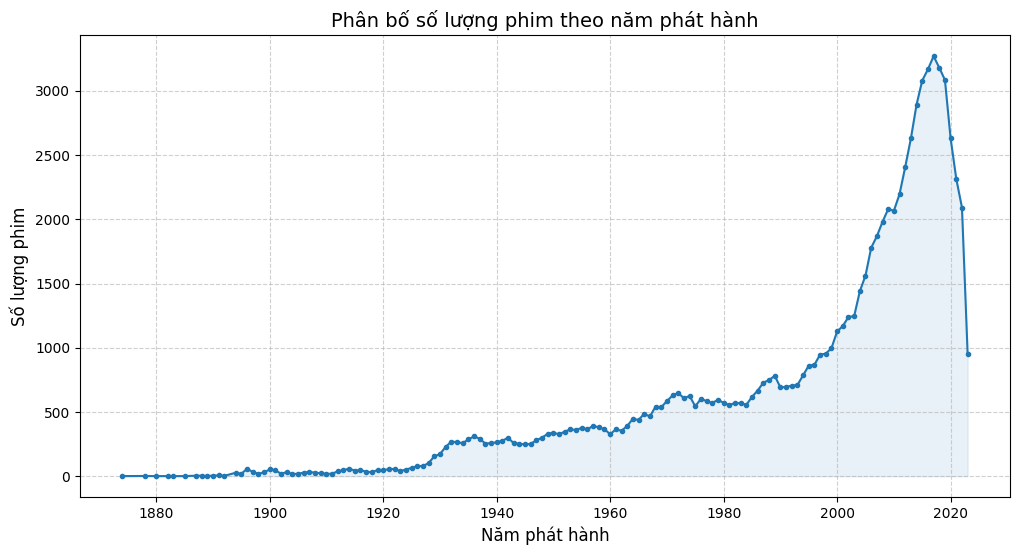

In [17]:
movies_per_year_df = movies.filter(col("ReleaseYear").isNotNull()) \
                           .groupBy("ReleaseYear") \
                           .count() \
                           .orderBy("ReleaseYear")

pdf = movies_per_year_df.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(pdf['ReleaseYear'], pdf['count'], marker='o', markersize=3, linestyle='-', color='#1f77b4')
plt.title('Phân bố số lượng phim theo năm phát hành', fontsize=14)
plt.xlabel('Năm phát hành', fontsize=12)
plt.ylabel('Số lượng phim', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.fill_between(pdf['ReleaseYear'], pdf['count'], color='#1f77b4', alpha=0.1)
plt.show()

#### 2.1.3. Về User

In [20]:
num_users = ratings.select("userId").distinct().count()

print(f"Tổng số lượng User (người dùng): {num_users:,}")

Tổng số lượng User (người dùng): 200,948


### 2.2. Khám phá dữ liệu đa biến

#### 2.2.1 Khám phá mối quan hệ giữa phim và rating

In [28]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

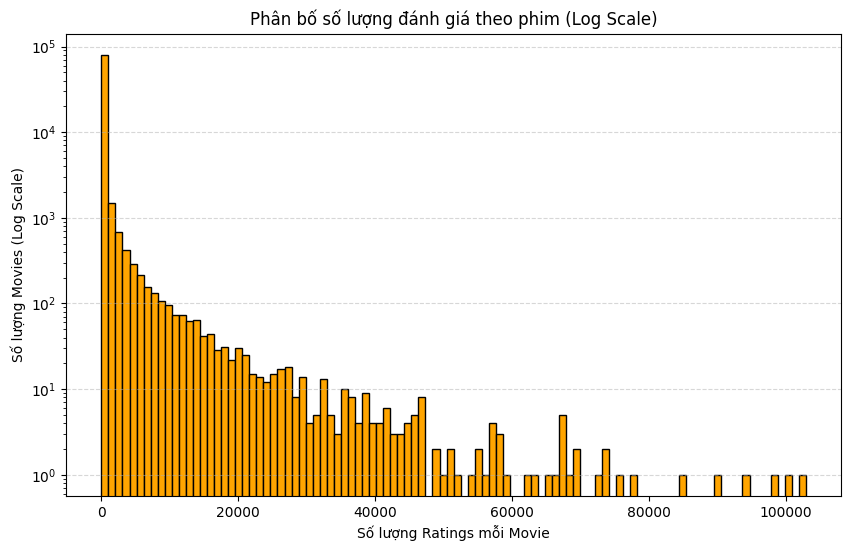

In [21]:
movie_rating_counts_df = ratings.groupBy("movieId").count()
movie_rating_counts_pd = movie_rating_counts_df.toPandas()
plt.figure(figsize=(10, 6))
plt.hist(movie_rating_counts_pd['count'], bins=100, edgecolor='black', color='orange', log=True)
plt.xlabel('Số lượng Ratings mỗi Movie')
plt.ylabel('Số lượng Movies (Log Scale)')
plt.title('Phân bố số lượng đánh giá theo phim (Log Scale)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [23]:
movie_counts = ratings.groupBy("movieId").count()
top_movies = movie_counts.join(movies, "movieId") \
                         .orderBy(desc("count")) \
                         .select("movieId", "title", "count")
print("--- Top 10 phim có nhiều lượt đánh giá nhất ---")
top_movies.show(10, truncate=False)

--- Top 10 phim có nhiều lượt đánh giá nhất ---


+-------+---------------------------------------------------------+------+
|movieId|title                                                    |count |
+-------+---------------------------------------------------------+------+
|318    |Shawshank Redemption, The (1994)                         |102929|
|356    |Forrest Gump (1994)                                      |100296|
|296    |Pulp Fiction (1994)                                      |98409 |
|2571   |Matrix, The (1999)                                       |93808 |
|593    |Silence of the Lambs, The (1991)                         |90330 |
|260    |Star Wars: Episode IV - A New Hope (1977)                |85010 |
|2959   |Fight Club (1999)                                        |77332 |
|480    |Jurassic Park (1993)                                     |75233 |
|527    |Schindler's List (1993)                                  |73849 |
|4993   |Lord of the Rings: The Fellowship of the Ring, The (2001)|73122 |
+-------+----------------

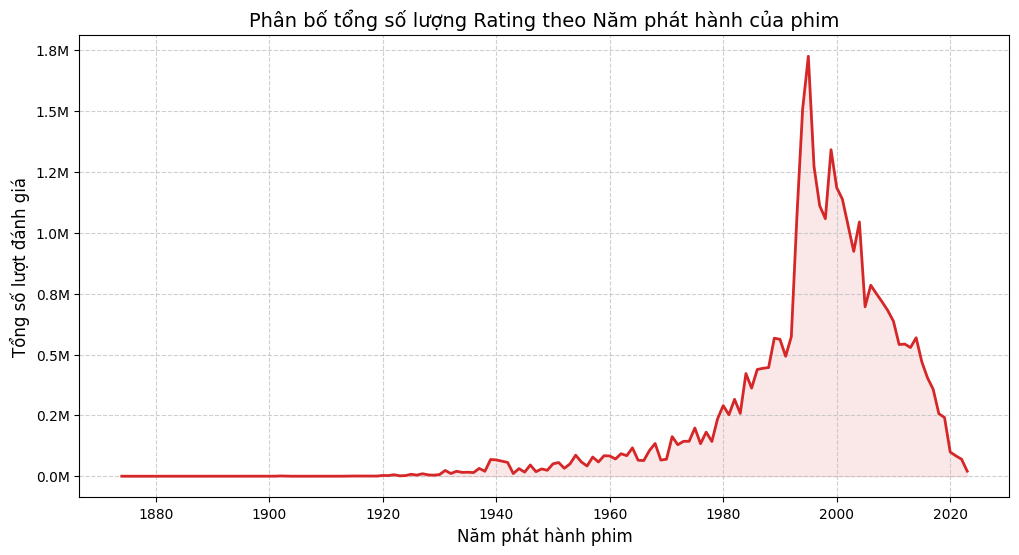

In [30]:
movie_rating_counts = ratings.groupBy("movieId").count().withColumnRenamed("count", "rating_count")

joined_df = movie_rating_counts.join(movies, "movieId") \
                               .filter(col("ReleaseYear").isNotNull())

ratings_by_release_year = joined_df.groupBy("ReleaseYear") \
                                   .agg(F.sum("rating_count").alias("total_ratings")) \
                                   .orderBy("ReleaseYear")
pdf = ratings_by_release_year.toPandas()
plt.figure(figsize=(12, 6))

plt.plot(pdf['ReleaseYear'], pdf['total_ratings'], color='#d62728', linewidth=2)
plt.fill_between(pdf['ReleaseYear'], pdf['total_ratings'], color='#d62728', alpha=0.1)
plt.title('Phân bố tổng số lượng Rating theo Năm phát hành của phim', fontsize=14)
plt.xlabel('Năm phát hành phim', fontsize=12)
plt.ylabel('Tổng số lượt đánh giá', fontsize=12)
def millions_formatter(x, pos):
    return f'{x/1000000:.1f}M'
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(millions_formatter))

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

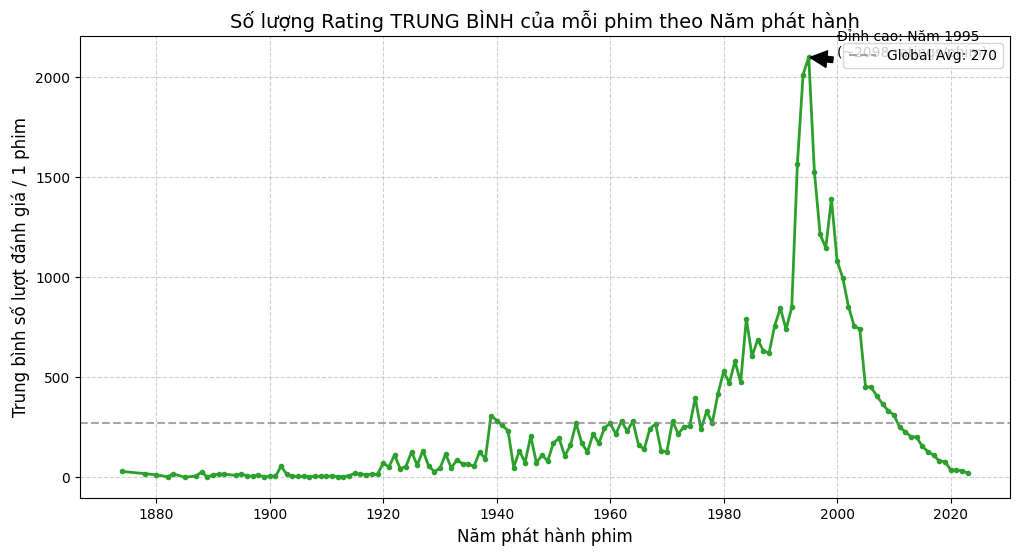

In [31]:
avg_ratings_per_year = joined_df.groupBy("ReleaseYear") \
    .agg(F.avg("rating_count").alias("avg_ratings_per_movie")) \
    .orderBy("ReleaseYear")
pdf_avg = avg_ratings_per_year.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(pdf_avg['ReleaseYear'], pdf_avg['avg_ratings_per_movie'], 
         color='#2ca02c', linewidth=2, marker='o', markersize=3)
plt.title('Số lượng Rating TRUNG BÌNH của mỗi phim theo Năm phát hành', fontsize=14)
plt.xlabel('Năm phát hành phim', fontsize=12)
plt.ylabel('Trung bình số lượt đánh giá / 1 phim', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
global_avg = pdf_avg['avg_ratings_per_movie'].mean()
plt.axhline(y=global_avg, color='gray', linestyle='--', alpha=0.7, label=f'Global Avg: {int(global_avg)}')
plt.legend()
max_row = pdf_avg.loc[pdf_avg['avg_ratings_per_movie'].idxmax()]
plt.annotate(f"Đỉnh cao: Năm {int(max_row['ReleaseYear'])}\n(~{int(max_row['avg_ratings_per_movie'])} ratings/phim)",
             xy=(max_row['ReleaseYear'], max_row['avg_ratings_per_movie']),
             xytext=(max_row['ReleaseYear'] + 5, max_row['avg_ratings_per_movie']),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

#### 2.2.2 Khám phá mối quan hệ giữa users và rating

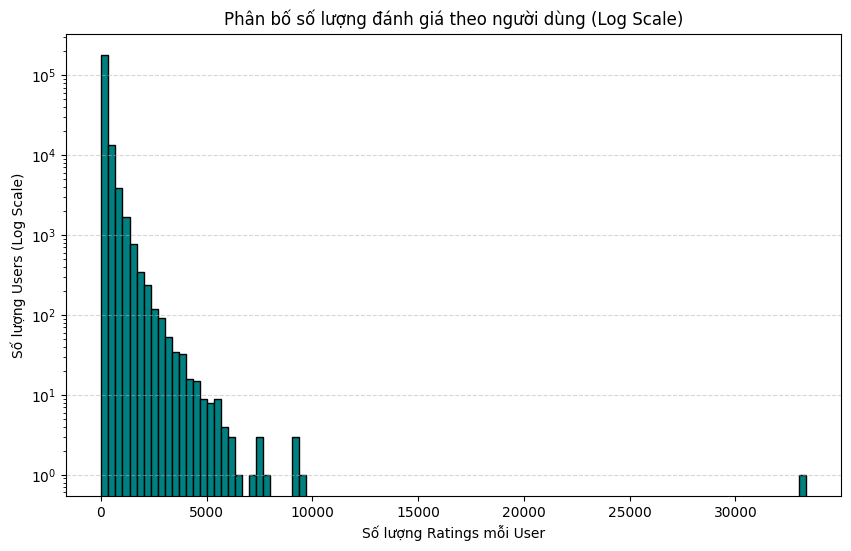

In [22]:
user_rating_counts_df = ratings.groupBy("userId").count()
user_rating_counts_pd = user_rating_counts_df.toPandas()
plt.figure(figsize=(10, 6))

plt.hist(user_rating_counts_pd['count'], bins=100, edgecolor='black', color='teal', log=True)

plt.xlabel('Số lượng Ratings mỗi User')
plt.ylabel('Số lượng Users (Log Scale)')
plt.title('Phân bố số lượng đánh giá theo người dùng (Log Scale)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

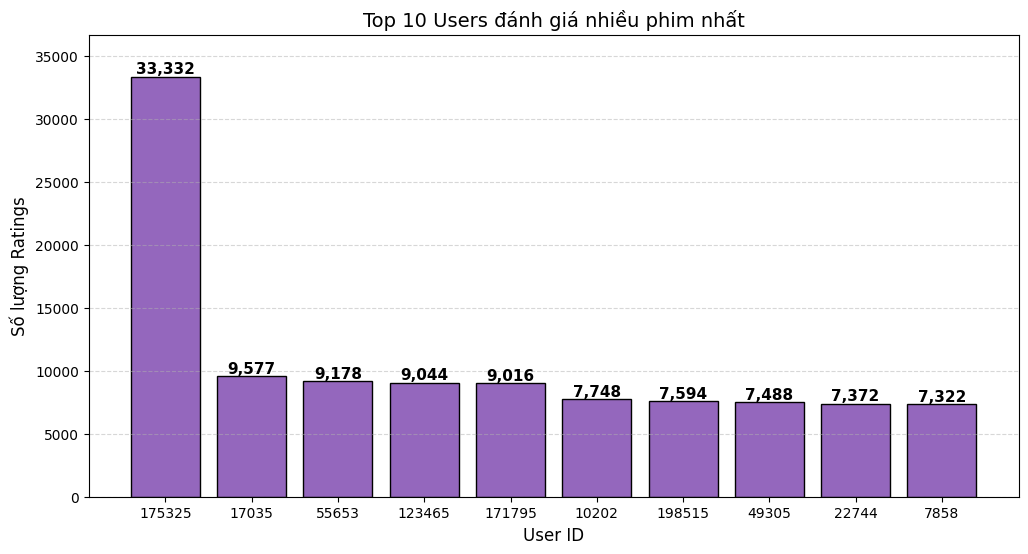

In [32]:
top_10_users = user_rating_counts_pd.sort_values(by='count', ascending=False).head(10)
top_10_users['userId'] = top_10_users['userId'].astype(str)
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_users['userId'], top_10_users['count'], color='#9467bd', edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval, 
        f'{int(yval):,}', # Format có dấu phẩy (ví dụ: 12,000)
        ha='center', 
        va='bottom', 
        fontsize=11, 
        fontweight='bold'
    )

plt.xlabel('User ID', fontsize=12)
plt.ylabel('Số lượng Ratings', fontsize=12)
plt.title('Top 10 Users đánh giá nhiều phim nhất', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, top_10_users['count'].max() * 1.1)

plt.show()

In [33]:
numerator = ratings.count()
num_users = ratings.select("userId").distinct().count()
num_movies = ratings.select("movieId").distinct().count()
denominator = num_users * num_movies

sparsity = (1.0 - (numerator * 1.0 / denominator)) * 100
print(f"The ratings dataframe is {sparsity:.4f}% empty.")

The ratings dataframe is 99.8114% empty.


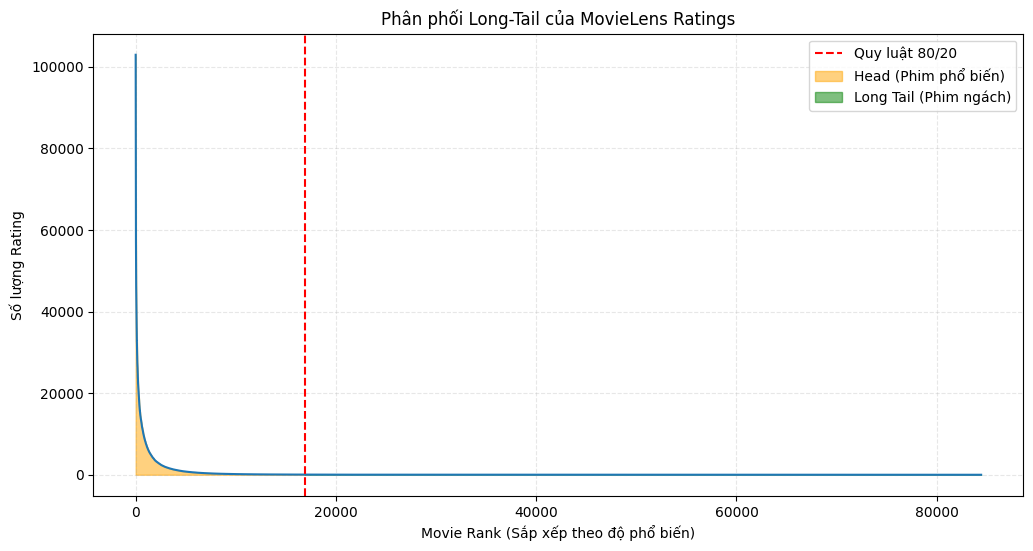

In [34]:
movie_counts = ratings.groupBy("movieId").count()
pdf_movie_counts = movie_counts.orderBy(col("count").desc()).toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pdf_movie_counts["count"].values)
plt.xlabel("Movie Rank (Sắp xếp theo độ phổ biến)")
plt.ylabel("Số lượng Rating")
plt.title("Phân phối Long-Tail của MovieLens Ratings")
plt.grid(True, linestyle='--', alpha=0.3)

head_size = int(len(pdf_movie_counts) * 0.2)
plt.axvline(x=head_size, color='red', linestyle='--', label='Quy luật 80/20')
plt.fill_between(range(head_size), pdf_movie_counts["count"][:head_size], color="orange", alpha=0.5, label="Head (Phim phổ biến)")
plt.fill_between(range(head_size, len(pdf_movie_counts)), pdf_movie_counts["count"][head_size:], color="green", alpha=0.5, label="Long Tail (Phim ngách)")

plt.legend()
plt.show()

In [35]:
total_ratings = pdf_movie_counts["count"].sum()
head_ratings = pdf_movie_counts["count"][:head_size].sum()
coverage = (head_ratings / total_ratings) * 100

print(f"Top 20% phim phổ biến nhất chiếm: {coverage:.2f}% tổng số lượt rating.")

Top 20% phim phổ biến nhất chiếm: 98.56% tổng số lượt rating.
